In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
N = 200 # number of points
n = 100 # number of samples/observations
p = 5 # number of variables/features

C = np.random.randint(0, 2, size=(p,p))
r = np.random.multivariate_normal(np.zeros(p), C @ C.T, size=(N, n))

t = np.linspace(0, 1, N)
x = np.cumsum((1/np.sqrt(N))*r, axis=0)

mu = np.mean(x, axis=1, keepdims=True)
x = x - mu

In [4]:
a = 20*t[:, np.newaxis, np.newaxis] + 2*np.random.random((1,n,1)) + 3*np.arange(p)[np.newaxis, np.newaxis, :]
x = (1+np.arange(p)[np.newaxis, np.newaxis, :])*np.sin(a)/2

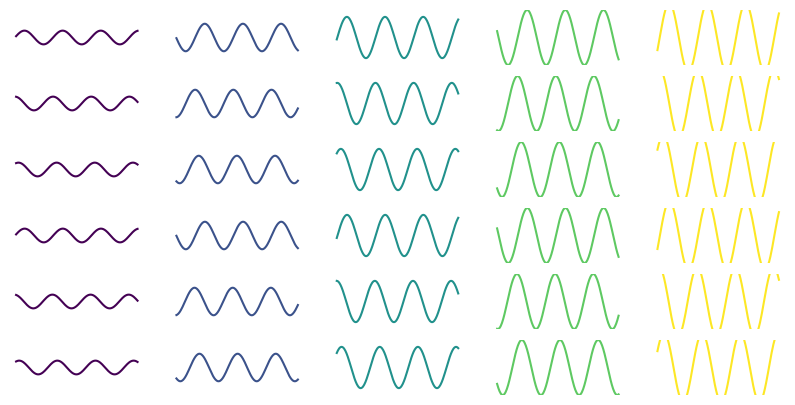

In [5]:
# plot a sample of 6 observations of the first 3 variables
fig, axs = plt.subplots(6, 5, figsize=(10, 5))
cmap = matplotlib.colormaps['viridis'].resampled(5)
for i in range(6):
    for j in range(5):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j))
        ax.set_axis_off()
        ax.set_ylim((-2,2))

In [6]:
x_hat = np.fft.fft(x, axis=0)
x_hat.shape

(200, 100, 5)

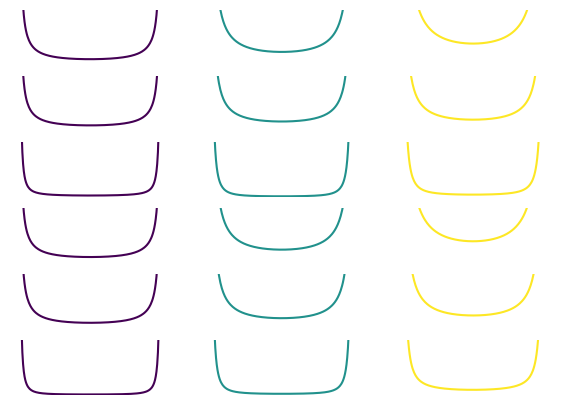

In [7]:
# plot a sample of 6 observations of the first 3 variables
fig, axs = plt.subplots(6, 3, figsize=(7, 5))
cmap = matplotlib.colormaps['viridis'].resampled(3)
for i in range(6):
    for j in range(3):
        ax = axs[i,j]
        ax.plot(t, np.absolute(x_hat[:, i,j]), c=cmap(j))
        ax.set_axis_off()
        ax.set_ylim((0,2))

In [8]:
cov = (x_hat.transpose(0,2,1) @ np.conjugate(x_hat)) / (n-1)

In [9]:
eigenvalues, eigenvectors = np.linalg.eigh(cov)
# Order the eigenvalues and eigenvectors by descending order
idx = np.argsort(eigenvalues, axis=1)[:, ::-1]
eigenvalues = np.take_along_axis(eigenvalues, idx, axis=-1)
eigenvectors = np.take_along_axis(eigenvectors, idx[:,np.newaxis,:], axis=-1)

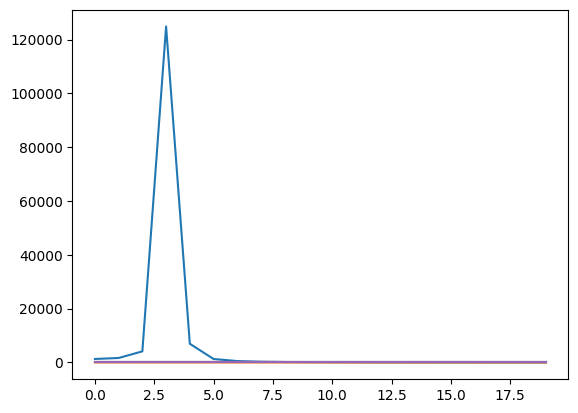

In [10]:
plt.plot(eigenvalues[:20])
plt.show()

In [11]:
# select correctly the sign of the eigenvectors
#for i in range(1, eigenvectors.shape[0]):
#    eigenvectors[i] *= np.sign(np.sum(eigenvectors[i] * eigenvectors[i-1], axis=0, keepdims=True))

In [276]:
eigenvectors_hat = np.fft.ifft(eigenvectors, axis=0)
eigenvectors_hat_conjugate = np.fft.ifft(eigenvectors.conjugate(), axis=0)

In [277]:
k=1

x_complex = x.astype(np.complex128)
Z = np.zeros((N+N-1, n, k), dtype=np.complex128)
for _n in range(n):
    for _p in range(p):
        for _k in range(k):
            Z[:, _n, _k] +=np.convolve(x_complex[:, _n, _p], eigenvectors_hat_conjugate[:, _p, _k], mode="full")

In [278]:
y = np.zeros((N+N+N-2, n, p), dtype=np.complex128)
for _n in range(n):
    for _p in range(p):
        for _k in range(k):
            y[:, _n, _p] += np.convolve(Z[:, _n, _k], eigenvectors_hat[:, _p, _k], mode="full")

In [279]:
#c_n = (Z.shape[0]-N)//2
y = y[:N]

In [280]:
print("Mean Square Error ", np.mean(np.square(np.absolute(y - x))))

Mean Square Error  0.08929773980788644


/home/Projects/Functional-Data-Analysis/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/Projects/Functional-Data-Analysis/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


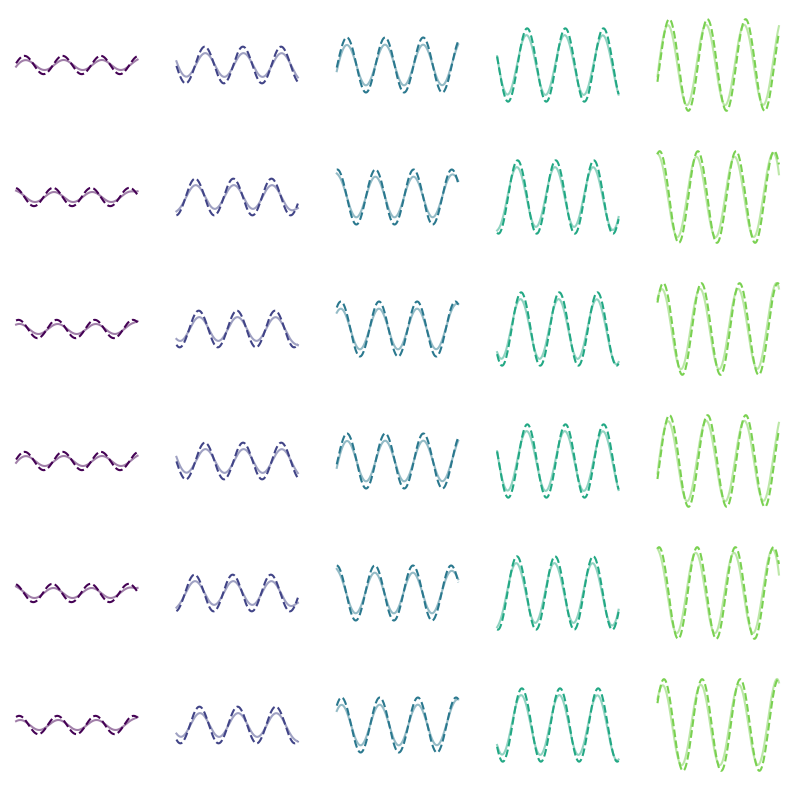

In [281]:
# plot a sample of n_r observations of the first n_c variables
n_r, n_c = 6, 5
fig, axs = plt.subplots(n_r, n_c, figsize=(10, 10))
cmap = matplotlib.colormaps['viridis'].resampled(n_c+1)
for i in range(n_r):
    for j in range(n_c):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j), linestyle='dashed')
        ax.plot(t, y[:, i,j], c=cmap(j), alpha=0.5)
        ax.set_axis_off()
        ax.set_ylim((-3,3))

In [161]:
k=1
Z = x_hat @ eigenvectors[:, :, :k].conjugate()
x_norm_hat = Z @ eigenvectors[:, :, :k].transpose(0,2,1)

In [162]:
x_norm_hat_hat = np.fft.ifft(x_norm_hat, axis=0)

In [163]:
print("Mean Square Error ", np.mean(np.square(x_hat - x_norm_hat)))

Mean Square Error  (0.016560939403519548-3.9790393202565616e-17j)


In [164]:
print("Mean Square Error ", np.mean(np.square(np.absolute(x - x_norm_hat_hat))))

Mean Square Error  0.0008024776880397698


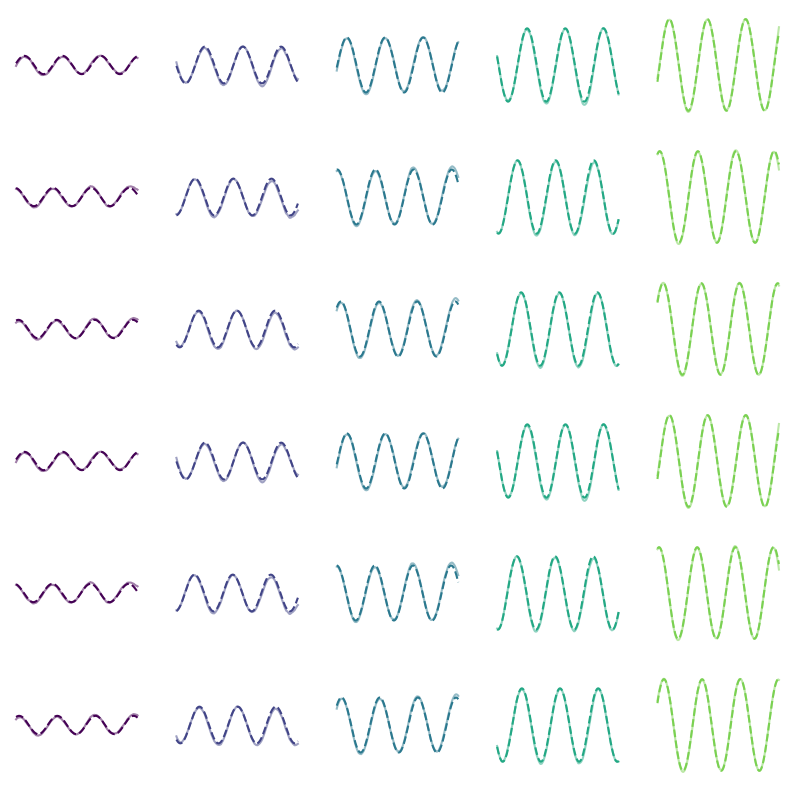

In [165]:
# plot a sample of n_r observations of the first n_c variables
n_r, n_c = 6, 5
fig, axs = plt.subplots(n_r, n_c, figsize=(10, 10))
cmap = matplotlib.colormaps['viridis'].resampled(n_c+1)
for i in range(n_r):
    for j in range(n_c):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j), linestyle='dashed')
        ax.plot(t, x_norm_hat_hat[:, i,j].real + mu[:, 0, j], c=cmap(j), alpha=0.5)
        ax.set_axis_off()
        ax.set_ylim((-3,3))